# 2D Linear Plane Strain Elasticity

<img src="fig/guinea_pig.png" alt="drawing" width="500"/>

## General formulation of the problem

---
Consider a rectangular domain $\Omega$ with a circular hole of radius $R$ at its center (see the following figure). The body is fixed at the bottom boundary $\Gamma_\mathrm{D}$ and a constant linear loading $\mathbf{g}$ is applied to the upper edge of the plate $\Gamma_\mathrm{N}$. Moreover, the body is under volumetric loading $\mathbf{b}$. We are interested in the shape deformation of the circle and the concentration of stress around its circumference.

In [1]:
%load_ext tikzmagic

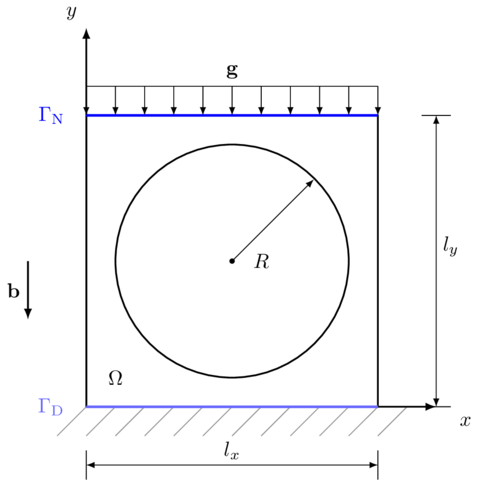

In [2]:
%%tikz -l patterns -s 900,480
\input{formulation.tikz};

### Governing equations
This boundary-value problem reads
\begin{equation}
\end{equation}
\begin{align}
    &&
    \mathrm{div}\boldsymbol{\sigma} + \mathbf{b}
    &=
    \mathbf{0} && \text{in}\ \Omega, \\
    &&
    \boldsymbol{\sigma} \mathbf{n}
    &=
    \mathbf{g}, && \text{on}\ \Gamma_N, \\
    &&
    \mathbf{u}
    &=
    \bar{\mathbf{u}}, && \text{on}\ \Gamma_D,
\end{align}
where $\mathbf{b}$ denotes a volumetric loading,
$\mathbf{g}$ is the surface loading
($\Gamma_\mathrm{N}$ beeing the upper part of the boundary where the Neumann boundary condition is prescribed),
and the Dirichlet boundary is applied on the bottom part of the boundary $\Gamma_\mathrm{D}$.
The Cauchy stress tensor $\boldsymbol{\sigma}$ is given by
\begin{align*}
    \boldsymbol{\sigma} =\lambda\mathrm{tr}(\boldsymbol{\varepsilon})\mathbf{I} + 2\mu\boldsymbol{\varepsilon}
\end{align*}
where the strain tensor $\boldsymbol{\varepsilon}$ is the symmetric part of the gradient of deformation
$\nabla\mathbf{u}$, i.e.
\begin{equation}
    \boldsymbol{\varepsilon}=\frac{1}{2}\left(\nabla\mathbf{u}+ \left( \nabla\mathbf{u} \right)^{\top} \right)\,,
\end{equation}
and $\lambda$ with $\mu$ are the Lame's parametres that can be expressed in terms of the Young's modulus $E$ and Poisson's ratio $\nu$
\begin{equation}
    \lambda = \frac{E \nu}{(1 + \nu) (1 - 2 \nu)},
    \qquad
    \mu = \frac{E}{2(1 + \nu)}\,.
\end{equation}



Multiplying the bulk equation by a test function $\delta\mathbf{u}$, integrating over the spatial domain $\Omega$, and integrating by parts yields the weak formulation of our problem: That is, find $\mathbf{u}$ such that $\mathbf{u}-\bar{\mathbf{u}} \in \mathbf{V}$ and
\begin{equation}
    \int_{\Omega} \boldsymbol{\sigma} : \delta \boldsymbol{\varepsilon} \, \mathrm{d}V = \int_{\Omega} \mathbf{b}\cdot\delta\mathbf{u} \, \mathrm{d}V + \int_{\Gamma_N}\mathbf{g}\cdot\delta\mathbf{u} \, \mathrm{d}S, \qquad \forall \delta\mathbf{u} \in \mathbf{V}\,,
\end{equation}
where $\mathbf{V} = \{ v \in H^1(\Omega; \mathbb{R}^2)| v = 0\ \text{on}\ \Gamma_\mathrm{D}\}$ is the function space for both the translated solution $\mathbf{u}-\bar{\mathbf{u}}$ and the test function $\delta\mathbf{u}$ and $\delta\boldsymbol{\varepsilon}$ is the symmetric part of the gradient $\nabla \delta\mathbf{u}$ and
\begin{align}
\mathbf{u} = \bar{\mathbf{u}}\,, & &\text{on}\ \Gamma_\mathrm{D},
\\
\delta\mathbf{u} = \mathbf{0}\,, & &\text{on}\ \Gamma_\mathrm{D}.
\end{align}


>note: The 2D in-plane stress formulation (accounting for an eventual thickening or narrowing of the material in the 3rd dimension) is analogical to the 3D formulation, with a minor change of the constitutive equation, namely
\begin{equation}
    \boldsymbol{\sigma} =\lambda^*\mathrm{tr}(\boldsymbol{\varepsilon})\mathbf{I} + 2\mu\boldsymbol{\varepsilon},
\end{equation}
where
\begin{equation}
    \lambda^* = \frac{2\lambda\mu}{\lambda + 2\mu}.
\end{equation}
It should be emphasized that this model does not consider buckling of the material.

## Implementation

---
Let us first import the necessary libraries and mark the bottom boundary. For our convenience, we define the stress function $\boldsymbol{\sigma}$.

In [3]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
# Bottom boundary
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))

# Strain function
def epsilon(u):
    return fe.sym(fe.grad(u))

# Stress function
def sigma(u):
    return lambda_*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)
# lambda is a reserved python keyword, naming convention recommends using a single trailing underscore for such cases

The function `bottom` defines a set of points that constitute the bottom boundary. Here, `x` represents a vector of spatial coordinates, i.e. `x[0]` is the $x$ coordinate, and `x[1]` is the $y$ coordinate. Function `sigma` defines the stress tensors as a function of the displacement field $\mathbf{u}$. The UFL language offers implementations of the standart differential and tensor operators, including the divergence `div`, symmetric part of the gradient `sym`, and the identity tensor `Identity`. Here is a short table of other, frequently used operators:

| FEniCS operators | Description |
| -- | -- |
| `grad(u)` | Gradient of function `u` |
| `div(u)` | Divergence of function `u` |
| `dot(u, v)` | Dot product between `u` and `v` |
| `inner(u, v)` | Inner product between `u` and `v` |
| `Identity(d)` | Identity tensor with dimension `d` |
| `sym(A)` | Symmetric part of `A` |
| `dev(A)` | Deviatoric part of `A` |
| `A.T` | Transposition of the tensor `A`|

For more, see the [documentation](https://fenicsproject.org/docs/ufl/1.6.0/ufl.html#ufl-package) of UFL (Unified Form Language, the language for expressing the weak forms).

### Problem parameters
Note that the vector loading $\mathbf{b}$ and $\mathbf{g}$ must be set as a tuple.

In [4]:
# --------------------
# Parameters
# --------------------
# Young's modulus and Poisson's ratio
E = 0.02e9
nu = 0.1

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
g_z = 1.0
b_z = 1.0
g = fe.Constant((0.0, g_z))
b = fe.Constant((0.0, b_z))

Moreover, we add the plane stress correction.

In [5]:
model = "plane_strain"

if model == "plane_stress":
    lambda_ = 2*mu*lambda_/(lambda_+2*mu)

### Geometry of the problem
The variable `mesh` points to the `RectangleMesh` object that contains the geometry of a rectangular mesh. We initialize the object specifying the lower left vertex and the upper right vertex (both in the form of the FEniCS object `Point`) followed by two integers denoting the discretization in the $x$ and $y$&nbsp;direction respectively.

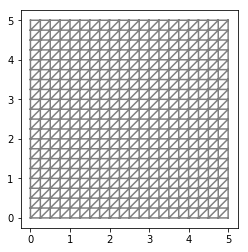

In [6]:
# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

fe.plot(mesh)
plt.show()

By default, the mesh is discretized with the triangles oriented to the "right". The orientation can be changed by adding the string `"left"` as the last (optional) argument.

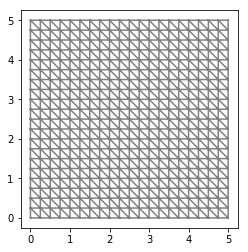

In [7]:
fe.plot(fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y, "left"))
plt.show()

Other types of mesh include `"crossed"`, which makes each of the `n_x*n_y` squares crossed, and `"left/right"`, which changes the orientation of the diagonal from one element to another.

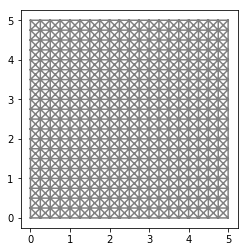

In [8]:
fe.plot(fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y, "crossed"))
plt.show()

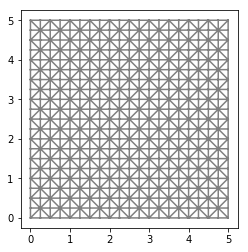

In [9]:
fe.plot(fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y, "left/right"))
plt.show()

Quadrilateral finite elements are also supported by FEniCS; a unit square mesh with quadrilateral discretization can be initialized by the `create()` method of the `UnitSquareMesh` object. We call it with the flag `CellType.Type.quadrilateral`.

In [10]:
mesh_quad = fe.UnitSquareMesh.create(n_x, n_y, fe.CellType.Type.quadrilateral)

Nevertheless, quadrilateral elements are not fully implemented in FEniCS, e.g., `plot()` is not applicable to these meshes.  
  
Other than elementary mesh geometries need to be imported into FEniCS. One possibility is to transfer the mesh from an external `.xml` file into the `Mesh` object.

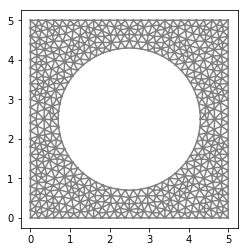

In [11]:
mesh = fe.Mesh("external_mesh.xml")
fe.plot(mesh)
plt.show()

The external `.xml` file can be generated for example using the [Gmsh](http://gmsh.info/) software. See [this](http://mypages.iit.edu/~asriva13/?page_id=586) short tutorial on generating meshes with Gmsh and importing it into FEniCS, or the full [documentation](http://gmsh.info/doc/texinfo/gmsh.html) if necessary.

### Function spaces definition
In this example, the trial and test functions are vector valued, thus we work with a cartesian product of the space $V$ ($V\times V$ in 2D and $V\times V\times V$ in 3D). In FEniCS, the `VectorFunctionSpace` object implements such space.

In [12]:
# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

We use the linear Lagrange elements again. Other types of elements, or approximation spaces, are summarized in the following table (more exhaustive list can be found [here](https://fenicsproject.org/olddocs/dolfin/1.3.0/python/programmers-reference/functions/functionspace/FunctionSpace.html))

| Keyword | Description |
| -- | -- |
| `"CG"` | Lagrange / Continous Galerkin |
| `"DG"` | Discountinous Galerkin |
| `"HER"` | Hermite elements - only partly supported |
| `"B"` | Bubble functions |

Vector function defined in this space must be defined using a tuple as

### Boundary conditions

#### Dirichlet boundary conditions
We repeat the initialization of the `DirichletBC` object representing the Dirichlet boundary conditions from the previous problem.

In [13]:
# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)

Alternatively, we can restrict displacements in one direction only. In such case, the first argument of `DirichletBC` is a subspace `V.sub(1)` of the vector function space `V`. For example the following piece of code prescribes zero displacement in the $y$-direction

In [14]:
bc = fe.DirichletBC(V.sub(1), 0.0, bottom)

#### Neumann boundary conditions
The top boundary can be created by the `SubDomain` object that is able to mark a subset of the domain specified by a given function. The function can be defined as a python class or as the compact `lambda` function.

In [15]:
top = fe.AutoSubDomain(lambda x: fe.near(x[1], l_y))

We mark the top boundary using the `MeshFunction` object, which is a function evaluated on mesh entities defined by the topological dimension (third argument of the `MeshFunction` initialization). The topological dimension 1 returns function on facets out two dimensional problem.

In [16]:
# Definition of Neumann boundary condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

Finally, we can label the sub-domain `top` by integer 1.

In [17]:
top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

### Weak formulation

The weak form is implemented using pre-defined FEniCS operators as follows

In [18]:
# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = fe.dot(b, u_test)*fe.dx - fe.inner(g, u_test)*ds(1)

The objects `dx` and `ds` represent the integration domain. The following table gives the three basic implemented integration domains.

| FEniCS object | Description |
| -- | -- |
| `dx` | Volume integration |
| `ds` | Outer boundary integration |
| `dS`| Internal boundary integration |

Moreover, integration domain accepts the optional argument which defines only part of the domain. For example domain `ds(1)` represents part of the outer boundary labelled with 1.

To solve the problem, it is possible to use `fe.solve(a==l, V, bc)` again. However, we introduce another solution that is useful when we need to access the system matrices directly. For this purpose FEniCS provides a function `assembly_system` with three arguments: the left-hand side of the problem, the right-hand side, and the Dirichlet boundary conditions. This function returns assembled matrix `A` of the system and a vector `L` of the right-hand side of the linear system. Assembling is based on the selected type of function space. The variational continuous system is converted into an algebraic system $\mathbf{A}\mathbf{x}=\mathbf{L}$. The regularity of $\mathbf{A}$ is affected e.g. by the mesh degeneracy, an improper set of boundary conditions, or by the insuffuciency of the numerical integration.

In [19]:
# --------------------
# Solver
# --------------------
u = fe.Function(V)
A, L = fe.assemble_system(a, l, bc)

FEniCS provides an overloaded function `solve` for solving linear systems that returns the vector of displacements $\mathbf{u}$. Therefore we must use `u.vector()`, which returns the `Vector` object, as the second argument.

In [38]:
problem = fe.LinearVariationalProblem(a,l,u,bc)
solver = fe.LinearVariationalSolver(problem)
#parameters = solver.parameters
parameters = fe.Parameters
parameters.str(True)
#fe.info(solver.parameters, verbose=True)

#fe.solve(A, u.vector(), L)

TypeError: str(): incompatible function arguments. The following argument types are supported:
    1. (self: dolfin.cpp.parameter.Parameters, arg0: bool) -> str

Invoked with: True

## Post-processing

---

Node values can be accessed by `.vector()` function. It returns an iterable `PETScVector` object which enables us to manipulate with nodal values. Since the displacement is a vector field, it cannot be plotted directly. We must specify scalar subspace for plotting of the results.

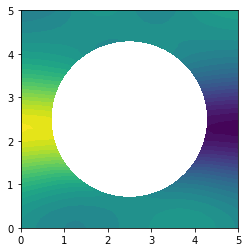

In [21]:
fe.plot(u.sub(0))
plt.show()

A second option for visualization of the result is to call an optional argument mode with value `"displacement"` which plots the displaced domain

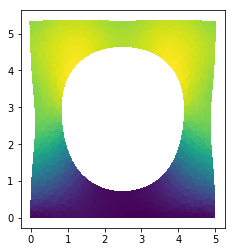

In [22]:
fe.plot(u*1.0e6, mode="displacement")
plt.show()

Stress can be plotted similarly but since it is a second-order tensor we must specify a scalar subspace by two indices. For example stress $\sigma_{yy}$ is obtained by `sigma(u)[1,1]`

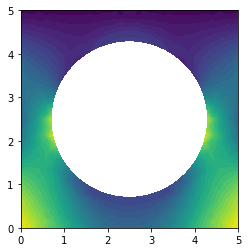

In [23]:
stress = sigma(u)
fe.plot(stress[1, 1])
plt.show()

This procedure is sufficient for plotting the components of $\boldsymbol{\sigma}$ or for reusing $\boldsymbol{\sigma}$ in another weak form. However, if we need to access stress nodal values, we must first project it onto a suitable space. The displacement field "lives" in `CG1`, so the corresponding space for stress is the `DG0` space. Moreover, since the stress is a second-order tensor we must define it as the `TensorFunctionSpace` object.

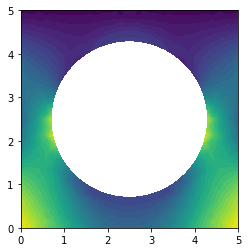

In [24]:
V0 = fe.TensorFunctionSpace(mesh, "DG", 0)
stress_1 = fe.project(stress, V0)
fe.plot(stress_1[1, 1])
plt.show()

<div class="alert alert-block alert-success">
    Projection of a function $u\in V$ onto a space $W$ means solving the following variational problem:
    \begin{equation}
    \text{Find}\,g\in W\,\text{s.t.}\,\int_\Omega uv\ \mathrm{d}V = \int_\Omega gv\ \mathrm{d}V,\ \forall v\in W.
    \end{equation}
</div>

Sometimes, it can be useful tool to convert a function into a non-corresponding space. However, the stress is obtained from the displacement by differentiation of the basis functions and thus the projection can be unnecessarily expensive. More effective way is to make the projection element-wise. Since we want to project the stress on the `DG0` space, where no continuity at nodes is required, we can perform this local projection without loss of generality. It can be done by the following subroutine:

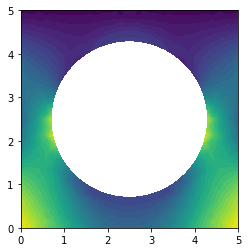

In [25]:
def local_project(fce, space):
    lp_trial, lp_test = fe.TrialFunction(space), fe.TestFunction(space)
    lp_a = fe.inner(lp_trial, lp_test)*fe.dx
    lp_L = fe.inner(fce, lp_test)*fe.dx
    local_solver = fe.LocalSolver(lp_a, lp_L)
    local_solver.factorize()
    lp_f = fe.Function(space)
    local_solver.solve_local_rhs(lp_f)
    return lp_f
stress_2 = local_project(stress, V0)
fe.plot(stress_1[1, 1])
plt.show()

## Complete code

---

4.00860760799e-07


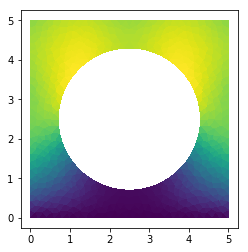

In [26]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))

# Strain function
def epsilon(u):
    return fe.sym(fe.grad(u))

# Stress function
def sigma(u):
    return lambda_*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
# Young's modulus and Poisson's ratio
E = 0.02e9
nu = 0.1

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
g_z = 1.0
b_z = 1.0
g = fe.Constant((0.0, g_z))
b = fe.Constant((0.0, b_z))

# Model type
model = "plane_strain"
if model == "plane_stress":
    lambda_ = 2*mu*lambda_/(lambda_+2*mu)

# --------------------
# Geometry
# --------------------
mesh = fe.Mesh("external_mesh.xml")

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], 5.0))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)

# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = fe.dot(b, u_test)*fe.dx - fe.inner(g, u_test)*ds(1)

# --------------------
# Solver
# --------------------
u = fe.Function(V)
A_ass, L_ass = fe.assemble_system(a, l, bc)

fe.solve(A_ass, u.vector(), L_ass)

print(np.amax(u.vector()[:]))

# --------------------
# Post-process
# --------------------
fe.plot(u, mode="displacement")
plt.show()